# Comparing Surface Interpolation for FX Options

This notebook will give a demonstration of *rateslib* interpolating its two different FX vol surface parametrisations: the **FXDeltaVolSurface** and the **FXSabrSurface**.

To reference a publication we will use Clark's *FX Option Pricing*, and establish an **FXForwards** market similar to the values he uses in his *Table 4.4* and and *Table 4.5*.

In [65]:
from rateslib import *
from pandas import DataFrame

eur = Curve({dt(2009, 5, 3): 1.0, dt(2011, 5, 10): 1.0})
usd = Curve({dt(2009, 5, 3): 1.0, dt(2011, 5, 10): 1.0})
fxf = FXForwards(
    fx_rates=FXRates({"eurusd": 1.34664}, settlement=dt(2009, 5, 5)),
    fx_curves={"eureur": eur, "usdusd": usd, "eurusd": eur},
)
fx_solver = Solver(
    curves=[eur, usd],
    instruments=[
        Value(dt(2009, 5, 4), curves=eur, metric="cc_zero_rate"),
        Value(dt(2009, 5, 4), curves=usd, metric="cc_zero_rate")
    ],
    s=[1.00, 0.4759550366220911],
    fx=fxf,
)

SUCCESS: `func_tol` reached after 4 iterations (levenberg_marquardt), `f_val`: 5.204923799977582e-16, `time`: 0.0030s


## Create a DeltaVolSurface

This will define and calibrate a DeltaVolSurface using the 1Y and 2Y instruments as defined in Clark's table.
Clark has pre-computed the forward deltas of the 1Y *Options* (since the market convention is for spot delta).
The *Options* used are -25d Put, ATM Call and 25d Call.

In [66]:
fxs = FXDeltaVolSurface(
    eval_date=dt(2009, 5, 3),
    expiries=[dt(2010, 5, 3), dt(2011, 5, 3)],
    delta_indexes=[0.25, 0.5, 0.75],
    node_values=[[5, 5, 5], [5, 5, 5]],
    delta_type="forward"
)

Calibrate to the stated volatilities.

The values used by Clark are as follows;

In [68]:
DataFrame(
   data=[
       [1.1964, 1.3620, 1.5501], [19.590, 18.250, 18.967],
       [1.1733, 1.3689, 1.5974], [19.068, 17.870, 18.485],
       [1.1538, 1.3748, 1.6393], [18.801, 17.677, 18.239]
   ],
   index=[("1y", "k"), ("1y", "vol"), ("18m", "k"), ("18m", "vol"), ("2y", "k"), ("2y", "vol")],
   columns=["25d Put", "ATM Put", "25d Call"]
)

,25d Put,ATM Put,25d Call
"(1y, k)",1.1964,1.3620,1.5501
"(1y, vol)",19.5900,18.2500,18.9670
"(18m, k)",1.1733,1.3689,1.5974
"(18m, vol)",19.0680,17.8700,18.4850
"(2y, k)",1.1538,1.3748,1.6393
"(2y, vol)",18.8010,17.6770,18.2390


In [69]:
op_args = dict(pair="eurusd", delta_type="forward", curves=[None, eur, None, usd], eval_date=dt(2009, 5, 3), vol=fxs, metric="vol")

vol_solver = Solver(
    surfaces=[fxs],
    instruments=[
        FXPut(expiry="1y", strike="-25d", **op_args),
        FXCall(expiry="1y", strike="atm_delta", **op_args),
        FXCall(expiry="1y", strike="25d", **op_args),
        FXPut(expiry="2y", strike="-25d", **op_args),
        FXCall(expiry="2y", strike="atm_delta", **op_args),
        FXCall(expiry="2y", strike="25d", **op_args),
    ],
    s=[19.59, 18.25, 18.967, 18.801, 17.677, 18.239],
    fx=fxf,
)
    

SUCCESS: `func_tol` reached after 10 iterations (levenberg_marquardt), `f_val`: 5.501481514056634e-17, `time`: 0.0165s


Now we will derive the interpolated Smile and the values for the 18 month *Options*.

In [70]:
result = FXPut(expiry="18m", strike="-25d", **op_args).analytic_greeks(fx=fxf)
{"strike": result["__strike"], "vol": result["__vol"]*100}

{'strike': <Dual: 1.172631, (27c6d__1_0, 27c6d__1_1, 27c6d__1_2, ...), [-0.0, -0.0, -0.0, ...]>,
 'vol': <Dual: 19.064734, (27c6d__1_0, 27c6d__1_1, 27c6d__1_2, ...), [0.7, -0.0, 0.0, ...]>}

In [71]:
result = FXCall(expiry="18m", strike="atm_delta", **op_args).analytic_greeks(fx=fxf)
{"strike": result["__strike"], "vol": result["__vol"]*100}

{'strike': <Dual: 1.368385, (27c6d__1_0, 27c6d__1_1, 27c6d__1_2, ...), [0.0, 0.0, -0.0, ...]>,
 'vol': <Dual: 17.867943, (27c6d__1_0, 27c6d__1_1, 27c6d__1_2, ...), [-0.0, 0.7, -0.0, ...]>}

In [72]:
result = FXCall(expiry="18m", strike="25d", **op_args).analytic_greeks(fx=fxf)
{"strike": result["__strike"], "vol": result["__vol"]*100}

{'strike': <Dual: 1.597111, (27c6d__1_0, 27c6d__1_1, 27c6d__1_2, ...), [0.0, -0.0, 0.0, ...]>,
 'vol': <Dual: 18.482183, (27c6d__1_0, 27c6d__1_1, 27c6d__1_2, ...), [-0.0, 0.0, 0.7, ...]>}

Formatted for easy display this gives the following for the **DeltaVolSMile** at 18M:

In [74]:
DataFrame(
   data=[[1.1726, 1.3684, 1.5971], [19.065, 17.868, 18.482]],
   index=[("18m", "k"), ("18m", "vol")],
   columns=["25d Put", "ATM Put", "25d Call"]
)

,25d Put,ATM Put,25d Call
"(18m, k)",1.1726,1.3684,1.5971
"(18m, vol)",19.0650,17.8680,18.4820


## Create a SabrSurface

The SABRSurface behaves differently in the way it interpolates. It will interpolate in strike between neighbouring *Smiles* and not perform the intermediate step of pre-calculating a *Smile* for a given expiry.

In [75]:
fxs2 = FXSabrSurface(
    eval_date=dt(2009, 5, 3),
    expiries=[dt(2010, 5, 3), dt(2011, 5, 3)],
    node_values=[[0.05, 1.0, 0.01, 0.01]]*2,
    pair="eurusd",
)

In [76]:
op_args2 = dict(pair="eurusd", delta_type="forward", curves=[None, eur, None, usd], eval_date=dt(2009, 5, 3), vol=fxs2, metric="vol")
vol_solver2 = Solver(
    surfaces=[fxs2],
    instruments=[
        FXPut(expiry="1y", strike="-25d", **op_args2),
        FXCall(expiry="1y", strike="atm_delta", **op_args2),
        FXCall(expiry="1y", strike="25d", **op_args2),
        FXPut(expiry="2y", strike="-25d", **op_args2),
        FXCall(expiry="2y", strike="atm_delta", **op_args2),
        FXCall(expiry="2y", strike="25d", **op_args2),
    ],
    s=[19.59, 18.25, 18.967, 18.801, 17.677, 18.239],
    fx=fxf,
)

SUCCESS: `func_tol` reached after 10 iterations (levenberg_marquardt), `f_val`: 3.32414052757772e-16, `time`: 0.0667s


In [77]:
result = FXPut(expiry="18m", strike="-25d", **op_args2).analytic_greeks(fx=fxf)
{"strike": result["__strike"], "vol": result["__vol"]*100}

{'strike': <Dual: 1.172217, (ef799__1_0, ef799__1_1, ef799__1_2, ...), [-0.4, 0.0, -0.0, ...]>,
 'vol': <Dual: 19.080550, (ef799__1_0, ef799__1_1, ef799__1_2, ...), [71.1, -1.5, 3.7, ...]>}

In [78]:
result = FXCall(expiry="18m", strike="atm_delta", **op_args2).analytic_greeks(fx=fxf)
{"strike": result["__strike"], "vol": result["__vol"]*100}

{'strike': <Dual: 1.368526, (ef799__1_0, ef799__1_1, ef799__1_2, ...), [0.2, 0.0, 0.0, ...]>,
 'vol': <Dual: 17.869832, (ef799__1_0, ef799__1_1, ef799__1_2, ...), [68.2, 1.2, 1.8, ...]>}

In [79]:
result = FXCall(expiry="18m", strike="25d", **op_args2).analytic_greeks(fx=fxf)
{"strike": result["__strike"], "vol": result["__vol"]*100}

{'strike': <Dual: 1.598496, (ef799__1_0, ef799__1_1, ef799__1_2, ...), [1.2, 0.1, 0.1, ...]>,
 'vol': <Dual: 18.511384, (ef799__1_0, ef799__1_1, ef799__1_2, ...), [71.7, 4.3, 3.6, ...]>}

Again for ease of display the values for the **SabrSmile** are as follows:

In [81]:
DataFrame(
   data=[[1.1722, 1.3685, 1.5985], [19.08, 17.870, 18.511]],
   index=[("18m", "k"), ("18m", "vol")],
   columns=["25d Put", "ATM Put", "25d Call"]
)

,25d Put,ATM Put,25d Call
"(18m, k)",1.1722,1.3685,1.5985
"(18m, vol)",19.0800,17.8700,18.5110


## Comparing the Surfaces

We can make a plot of the comparison between the volatility values on of the interpolated *DeltaVolSurface* and the *SabrSurface*.
This requires setting up an *FXCall* at different strikes and calculating the associated volatility.

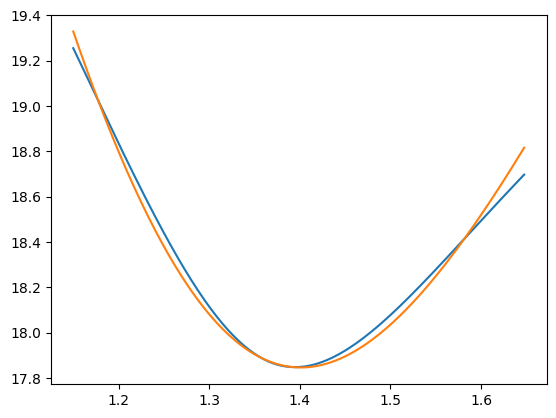

In [82]:
strikes = [1.15 + _ * 0.0025 for _ in range(200)]
options = [FXCall(expiry="18m", strike=_, **op_args) for _ in strikes]
options2 = [FXCall(expiry="18m", strike=_, **op_args2) for _ in strikes]

import matplotlib.pyplot as plt

fix, ax = plt.subplots(1,1)
ax.plot(strikes, [_.rate(fx=fxf) for _ in options])
ax.plot(strikes, [_.rate(fx=fxf) for _ in options2])